In [1]:
import numpy as np
import logging
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import heart_disease.plotting as hdp
import heart_disease.preprocessing as pre_proc
import seaborn as sns
import pandas as pd
from copy import deepcopy as cp
%load_ext autoreload

from heart_disease.globals import code_path, raw_data_path, data_path, output_path


from sklearn.pipeline import Pipeline
from sklearn.linear_model import perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import learning_curve, ShuffleSplit, StratifiedShuffleSplit

%autoreload 2

In [2]:
# Get Metadata
meta_data_df = pd.read_csv(data_path+'meta_data.csv')
meta_data_df.head()

,name,datatype,description,id
0,age,numeric,age in years,3
1,sex,bool,sex (1 = male; 0 = female),4
2,cp,categorical,chest pain type\r -- Value 1: typical angina...,9
3,trestbps,numeric,resting blood pressure (in mm Hg on admission ...,10
4,chol,numeric,serum cholestoral,12


In [3]:
# Import Raw Data
data_file_name_str = 'train_validation.cleveland.csv'
data_df = pre_proc.load_data(data_path+data_file_name_str)
data_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,ispos_truth
pat_id,,,,,,,,,,,,,,
162,54.0,0.0,3.0,110.0,214.0,0.0,0.0,158.0,0.0,1.6,2.0,0.0,3.0,False
18,48.0,0.0,3.0,130.0,275.0,0.0,0.0,139.0,0.0,0.2,1.0,0.0,3.0,False
100,45.0,1.0,4.0,115.0,260.0,0.0,2.0,185.0,0.0,0.0,1.0,0.0,3.0,False
78,48.0,1.0,2.0,130.0,245.0,0.0,2.0,180.0,0.0,0.2,2.0,0.0,3.0,False
262,60.0,0.0,1.0,150.0,240.0,0.0,0.0,171.0,0.0,0.9,1.0,0.0,3.0,False


In [4]:
dc = pre_proc.DataCleaner(data_path+'meta_data.csv') 

In [5]:
clean_df = dc.get_clean_dataframe(data_df)

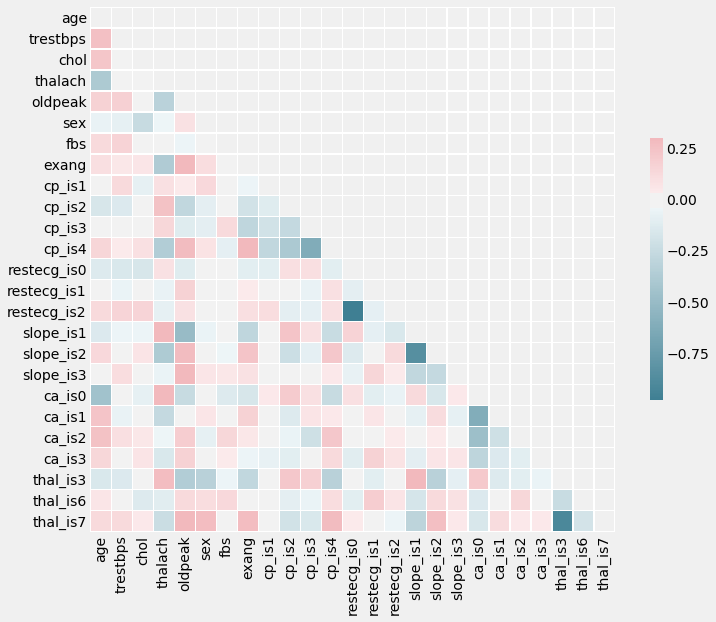

In [7]:
hdp.correlation_matrix(clean_df)
plt.savefig(output_path + 'correlation.png', bbox_inches='tight')
plt.show()